# 0) Initialization

In [41]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

import pickle
import sys

In [2]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/'

In [3]:
MSE = xr.open_mfdataset(path+'????/??MSE.nc',combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
MSE

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 162888)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-07-31T23:00:00
Data variables:
    p61.162    (time, latitude, longitude) float32 dask.array<shape=(162888, 721, 1440), chunksize=(744, 721, 1440)>
    p62.162    (time, latitude, longitude) float32 dask.array<shape=(162888, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-25 15:55:44 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

# 1) Save IQR,MED,MMI of column water vapor in time

In [77]:
dt = 3600
tcoor = dt*np.arange(0,MSE.time.shape[0])

In [72]:
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [13]:
YEAR = np.linspace(2000,2018,19).astype(int)
print(YEAR)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


In [15]:
year = 1993
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
print(date1,date2)

1993-01-01T00:00:00 1993-12-31T23:00:00


Interquartile range

In [19]:
IQ = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    IQ[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    IQ[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),75,axis=(1,2))-\
    np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),25,axis=(1,2))

Median

In [119]:
MED = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    MED[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    MED[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),50,axis=(1,2))

Moist Margin Index

i= 0  & year= 2000
Measuring contour length


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/tbeucler/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-139-dac39dc67e60>", line 10, in <module>
    Contour = curve.get_contours(MSEAtl.sel({'time':date})[0,:,:]>MED_data['Median_MSE'][str(year)][it])
  File "/nfs/twcroninlab002/tbeucler/2019_WMI/dev/tbeucler/util/curvature.py", line 9, in get_contours
    contours = (find_contours(bFMSE[:,:], 0))
  File "/home/tbeucler/miniconda3/lib/python3.7/site-packages/skimage/measure/_find_contours.py", line 110, in find_contours
    array = np.asarray(array, dtype=np.double)
  File "/home/tbeucler/miniconda3/lib/python3.7/site-packages/numpy/core/numeric.py", line 538, in asarray
    return array(a, dtype, copy=False, order=order)
  File "/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/core/common.py", line 105, in __array__
    return np.asarray(self.values

KeyboardInterrupt: 

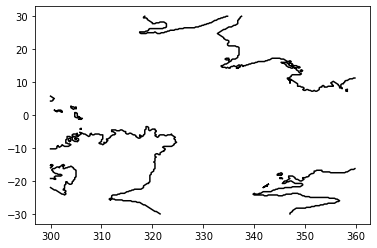

In [139]:
L_CONTOUR = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year)
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    Nt = MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0]
    L_CONTOUR[str(year)] = np.zeros((Nt,))
    for it in range(Nt):
        print('it=',it,'               ',end='\r')
        Contour = curve.get_contours(MSEAtl.sel({'time':date})[0,:,:]>MED_data['Median_MSE'][str(year)][it])
        L = 0
        for j,contour in enumerate(Contour):
            plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
            L += np.sum(contour*dx)
        L_CONTOUR[str(year)][it] = L

In [140]:
L_CONTOUR

{'2000': array([8629335.,       0.,       0., ...,       0.,       0.,       0.])}

Save interquartile range and median time series to not have to re-calculate it

In [121]:
# hf = open('PKL_DATA/8_13_IQ.pkl','wb')
# hf = open('PKL_DATA/10_1_MED.pkl','wb')
# # IQ_data = { "Interquartile_range_MSE" : IQ, "time" : MSEAtl.time }
# # pickle.dump(IQ_data,hf)
# MED_data = { "Median_MSE" : MED, "time" : MSEAtl.time }
# pickle.dump(MED_data,hf) 
# hf.close()

# 2) Analyze most aggregated case (as measured by IQ range) among all years

In [7]:
hf = open('PKL_DATA/8_13_IQ.pkl','rb')
IQ_data = pickle.load(hf)

In [122]:
hf = open('PKL_DATA/10_1_MED.pkl','rb')
MED_data = pickle.load(hf)

In [34]:
YEAR = np.linspace(2000,2018,19).astype(int)
max_year = np.zeros((YEAR.size,))
min_year = np.copy(max_year)
for i,year in enumerate(YEAR):
    max_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].max()
    min_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].min()

In [54]:
for data in max_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:02.0f}'.format(data/1e6))
print(' ')
for data in min_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:02.0f}'.format(data/1e6))

  91  91  93  93  89  93  89  89  92  88  100  92  89  90  90  86  90  93  84 
  44  41  41  45  43  45  41  44  47  43  43  43  43  40  45  44  43  46  46

In [69]:
imax = np.argmax(IQ_data['Interquartile_range_MSE']['2010'])
print('imax=',imax,' & IQ[imax]=',IQ_data['Interquartile_range_MSE']['2010'][imax]/2.5e6)

imax= 2433  & IQ[imax]= 39.9507968


Text(0, 0.5, 'IQ [kg/m2]')

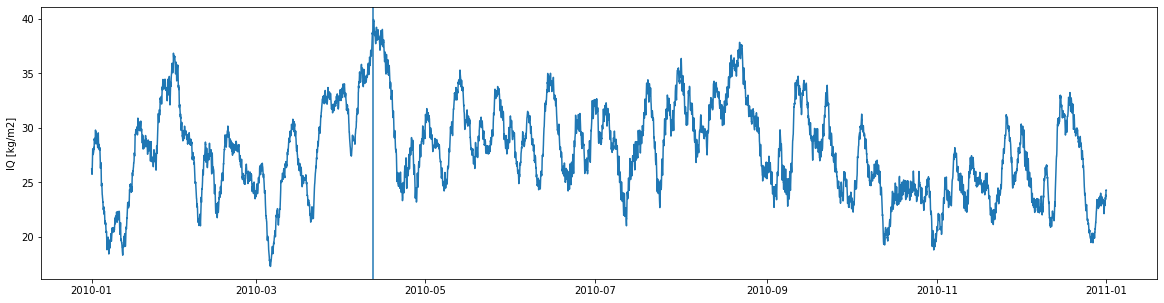

In [82]:
year = 2010
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2000 = MSEAtl.time.sel({'time':slice(date1,date2)})

plt.figure(figsize=(20,5))
plt.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6)
plt.axvline(t2000[2433].values)
plt.ylabel('IQ [kg/m2]')

In [87]:
imin_left = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax-1000:imax])+imax-1000

In [94]:
imin_right = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax:imax+1000])+imax

Text(0, 0.5, 'IQ [kg/m2]')

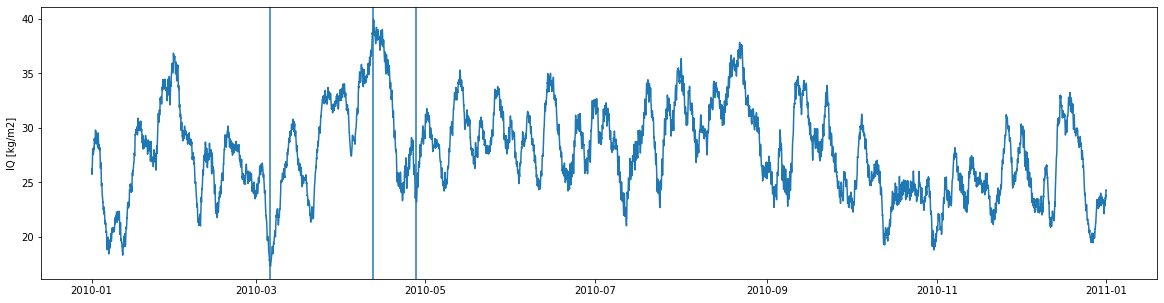

In [95]:
plt.figure(figsize=(20,5))
plt.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6)
plt.axvline(t2000[imax].values)
plt.axvline(t2000[imin_left].values)
plt.axvline(t2000[imin_right].values)
plt.ylabel('IQ [kg/m2]')

In [96]:
LSM = xr.open_mfdataset(path+'ERA_LANDSEAMASK.nc')

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [98]:
def index_date(time_array,date_string):
    return [i for i, x in enumerate(time_array.sel({'time':date_string})==time_array) if x]

In [110]:
def date_index(time_array,time_index):
    return time_array[time_index].values

In [125]:
iJan1_2010 = index_date(MSEAtl.time,'2010-01-01T00:00:00')

In [126]:
iJan1_2010

[87672]

i= 0  & date= ['2010-03-06T07:00:00.000000000']
Defining moist margin
Measuring contour length
i= 1  & date= ['2010-04-12T09:00:00.000000000']
Defining moist margin
Measuring contour length
i= 2  & date= ['2010-04-27T20:00:00.000000000']
Defining moist margin
Measuring contour length


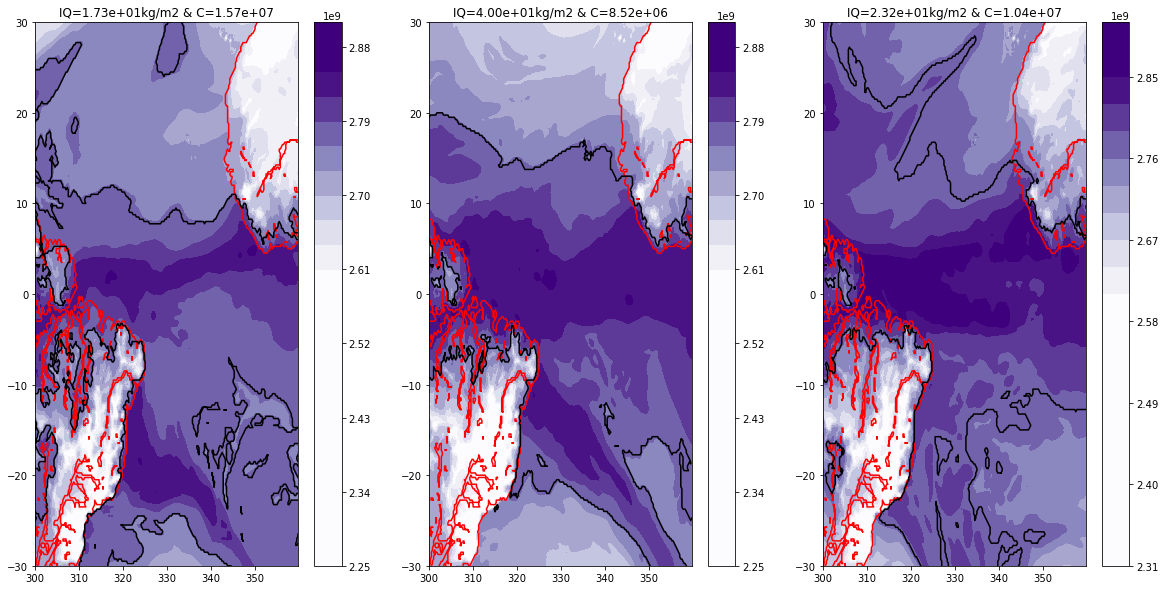

In [138]:
dx = 110/4
vmin = 2.6e9
vmax = 2.85e9

Tstr2010 = [imin_left,imax,imin_right]

plt.figure(figsize=(20,10))

for i,it2010 in enumerate(Tstr2010):
    it = it2010+iJan1_2010
    date = MSEAtl.time[it].values
    print('i=',i,' & date=',date)
    plt.subplot(1,3,i+1)
    plt.contourf(lonAtl,latAtl,MSEAtl.sel({'time':date})[0,:,:],cmap='Purples',levels=20,vmin=vmin,vmax=vmax)
    
    Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)
    for j,contour in enumerate(Land):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='r')
    
    print('Defining moist margin')
    Contour = curve.get_contours(MSEAtl.sel({'time':date})[0,:,:]>MED_data['Median_MSE']['2010'][it2010])
    print('Measuring contour length')
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    plt.colorbar()
    plt.title('IQ='+"%0.2e"%(IQ_data['Interquartile_range_MSE']['2010'][it2010]/2.5e6)+'kg/m2 & C='+"%0.2e"%L)